# Testing SAM Model

In [1]:
!pip install customtkinter
!pip install segment-anything
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install supervision

In [2]:
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import platform
import numpy as np
import torchvision
import cv2
import PIL
import tkinter as tk
from tkinter.filedialog import askopenfilename
from tkinter import *
from PIL import ImageTk, Image
import customtkinter as ctk
from customtkinter import *
import os
import sys
import supervision as sv
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

HOME = os.getcwd()
print("HOME:", HOME)


CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))


HOME: c:\Users\ldrakele\Downloads
c:\Users\ldrakele\Downloads\weights\sam_vit_h_4b8939.pth ; exist: True


C:/Users/ldrakele/Downloads/IMG_9928.jpeg


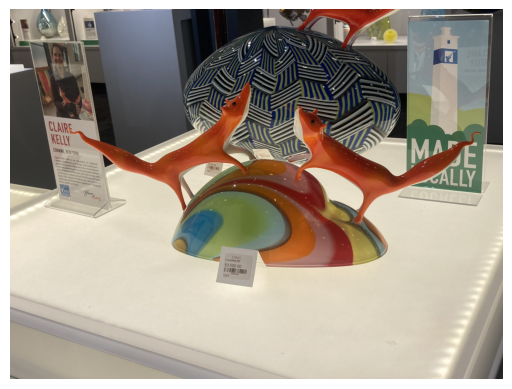

In [3]:
path = askopenfilename()
print(path)
assert path is not None, "No file selected"

image_bgr = cv2.imread(path)

assert image_bgr is not None, "No image selected"
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(image_rgb)

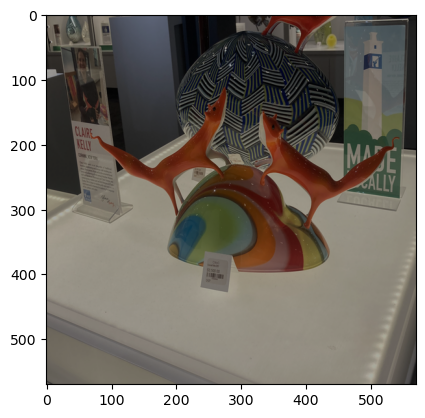

In [4]:
ctk.set_appearance_mode("Dark")
ctk.set_default_color_theme("blue")

class England(ctk.CTk):


    def __init__(self):
    #sets instance SAM variables and creates window
        super().__init__()

        self.title("ENGLAND")
        self.geometry("1700x1000")

        self.points_per_side = tk.IntVar()
        self.points_per_side.set(18)
        self.pred_iou_thresh = tk.DoubleVar()
        self.pred_iou_thresh.set(0.6)
        self.stability_iou_thresh = tk.DoubleVar()
        self.stability_iou_thresh.set(0.6)
        self.crop_n_layers = tk.IntVar()
        self.crop_n_layers.set(0)
        self.zoom = tk.IntVar()
        self.zoom.set(0)

        self.mode = tk.BooleanVar()
        self.mode.set(True)

        self.width=570
        self.height=570

        self.image_rgb = Image.open(path).convert('RGB') #converts to PIL image, in RGB format
        self.image_rgb = self.image_rgb.resize((self.width,self.height), Image.LANCZOS) #resizes image, also will correlate masks
        self.image_array = np.array(self.image_rgb, dtype=np.uint8) #converts rgba image to array 

        self.brighten_factor = 1.5
        self.image_array = np.clip(self.image_array[:,:,:3]/self.brighten_factor, 0, 255).astype(np.uint8) #dims array by making all r,g,b values smaller than their normal selves, then converting any float vals to ints (0 to 255 scale of brightness)
        self.image_array = np.flipud(np.fliplr(self.image_array)) #makes it not backwards and upside-down

        self.create_SAM()
        self.run_SAM(self.image_array)
        plt.imshow(self.image_array)
        plt.show()

        if self.image_array.shape[2] == 4:
            self.image_array = self.image_array[:, :, :3]
        
        self.static_image_array = np.copy(self.image_array)
        #self.image_array = np.uint8(self.image_array)
        self.final_img = Image.fromarray(np.uint8(self.image_array)) #converts image array to image
        self.final_img = ImageTk.PhotoImage(self.final_img) #makes image tkinter-friendly

        #creates buttons and grids them
        
        self.add_mask_button = ctk.CTkButton(self, text="Add Mask",height=90,width=350,font=("Times New Roman", 55),text_color="black",fg_color="#04ff00",hover_color="#04ad02",corner_radius = 15,
                                                command=self.add_mask
                                                )
        
        self.run_SAM_button = ctk.CTkButton(self,text="RUN SAM",height=70,width=300,font=("Times New Roman", 55),text_color="black",fg_color="#00ff77",hover_color="#02b857",corner_radius = 15,
                                            command=lambda: self.run_SAM(self.static_image_array)
         )
        
        self.delete_mask_button = ctk.CTkButton(self, text="Delete Mask",height=90,width=350,font=("Times New Roman", 55),text_color="black",fg_color="red",hover_color="#ba0202",corner_radius = 15,
                                                command=self.delete_mask
                                                )
        
        self.settings_button = ctk.CTkButton(self, text="Settings",height=50,width=175,font=("Times New Roman", 35),text_color="white",fg_color="#a6a6a6",hover_color="#6b6b6b",corner_radius = 15,
                                                command=self.access_settings,
                                                )
        
        self.plus_button = ctk.CTkButton(self, text="+", height=100, width=100, text_color='white', corner_radius=100, fg_color='green', font=('Arial', 70), hover_color='#10ad10', text_color_disabled='#808080',
                                         command=self.plus, state='normal')
        
        self.minus_button = ctk.CTkButton(self, text="-", height=100, width=100, text_color='white', corner_radius=100, fg_color='red', font=('Arial', 89), hover_color = '#a80b00', text_color_disabled='#808080',
                                         command=self.minus, state='disabled')

        self.mask_indices = tk.StringVar()

        self.mask_tracker = ctk.CTkLabel(self, text=self.mask_indices.get(), font=("Arial", 35), text_color="white",)
        self.get_relevant_masks()

        self.add_mask_button.grid(row=0, column=0, pady=30, padx=100)
        self.delete_mask_button.grid(row=0, column=1, padx=100)
        self.settings_button.grid(row=0, column=2, padx=100)
        self.run_SAM_button.grid(row=1, column=2, padx=100)
        self.mask_tracker.grid(row=1, column=0, pady=40)
        save_as_file_button = ctk.CTkButton(self, text="SAVE IMAGE", width=240, height=75, fg_color="#FF450F", font=('Times New Roman', 50), text_color='black', hover_color="#E42800", corner_radius=15,
                                            command=self.save_as_file)
        
        save_as_file_button.grid(row=2, column=0)

        #creates image, puts it on canvas, and grids canvas
        #also keeps in mind a certain width and height of 
        #how the final image will be displayed (that resized image = self.final_img)
        #creates and grids canvas that displays dimmed image

        self.image_display_canvas = ctk.CTkCanvas(self, width=self.width, height=self.height)
        self.image_display_canvas.grid(row=2, column=1)
        self.plus_button.place(x=1200,y=370)
        self.minus_button.place(x=1208,y=530)

        #displays final_img

        self.image_display_canvas.create_image(0, 0, image=self.final_img, anchor="nw")

        self.image_display_canvas.bind('<Motion>', self.hover_mask)
        self.image_display_canvas.bind('<Button-1>', self.click_mask)
        self.selected_mask = None



    #creates settings tab, with entryboxes and buttons

    def access_settings(self):
        settings_window = ctk.CTkToplevel(self, fg_color="#b0b0b0")
        settings_window.title("Settings")
        settings_window.geometry("850x500")

                                        
        points_per_side_entrybox = ctk.CTkEntry(settings_window,
                                    placeholder_text=self.points_per_side.get(),
                                    height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                    textvariable=self.points_per_side
                                    )
            
        points_per_side_entrybox.grid(padx=10)
        pps_label = ctk.CTkLabel(settings_window, text="\nNumber of points on each side, considered by SAM Model. \nMore points increases accuracy and analyzing time.\n", font=("Times New Roman", 18), text_color="black")
        pps_label.grid(row=0, column=1, padx=20)

        #creates an entrybox for pred_iou_thresh, alongside an explanatory label

        pred_iou_thresh_entrybox = ctk.CTkEntry(settings_window,
                                     placeholder_text=self.pred_iou_thresh.get(),
                                     height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                     textvariable=self.pred_iou_thresh
                                     )
        
        pred_iou_thresh_entrybox.grid()
        pit_label = ctk.CTkLabel(settings_window, text="\n0-1 scale, Filters masks based on accuracy.\n Higher filters are more selective, and take less time to analyze.\n", font=("Times New Roman", 18), text_color="black")
        pit_label.grid(row=1, column=1, padx=20)

        #creates an entrybox for stability_iou_thresh, alongside an explanatory label
        stability_score_thresh_entrybox = ctk.CTkEntry(settings_window,
                                     placeholder_text=self.stability_iou_thresh.get(),
                                     height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                     textvariable=self.stability_iou_thresh
                                     )
        
        stability_score_thresh_entrybox.grid()
        sst_label = ctk.CTkLabel(settings_window, text="\n0-1 scale, Filters masks based on how often they appear in all masks \n generated on an image. Higher filters are more selective, \nand take less time to analyze.\n", font=("Times New Roman", 18), text_color="black")
        sst_label.grid(row=2, column=1, padx=20)

        #creates an entrybox for crop_n_layers, alongside an explanatory label
        crop_n_layers_entrybox = ctk.CTkEntry(settings_window,
                                     placeholder_text=self.crop_n_layers.get(),
                                     height=50,width=100,font=("Times New Roman", 16),corner_radius=15,
                                     textvariable=self.crop_n_layers
                                     )
        
        crop_n_layers_entrybox.grid()
        cnl_label = ctk.CTkLabel(settings_window, text="\nNumber of additional layers of image that are analyzed, to compare any masks \nbetween layers. More layers catch more masks, and take longer to analyze.\n", font=("Times New Roman", 18), text_color="black")
        cnl_label.grid(row=3, column=1, padx=20)

        save_SAM_settings_button = ctk.CTkButton(settings_window, text="UPDATE SAM", width=600, height=80, fg_color='#00ffff', font=('Times New Roman', 50), text_color='black', hover_color="#00BDAF",
                                                      command=self.create_SAM)
        
        save_SAM_settings_button.grid(row=4, column=1, pady=50)

    
    def save_as_file(self):
        canvas_image_get = ImageTk.getimage(self.canvas_image)
        c_image = np.array(canvas_image_get, dtype=np.uint8)

        if(self.selected_mask is not None):
            c_image[self.selected_mask['segmentation']] = np.clip(c_image[self.selected_mask['segmentation']]/self.brighten_factor, 0, 255).astype(np.uint8) #darkens to original
            
        c_image = np.clip(c_image[:,:,:3]*self.brighten_factor, 0, 255).astype(np.uint8)

        file_path = filedialog.asksaveasfilename(initialfile=os.path.splitext(path)[0]+"_MASKED.tif",
                                                  defaultextension=".tif" ,filetypes=[("TIF files", "*.tif")])

        if file_path:
            cv2.imwrite(file_path, cv2.cvtColor(c_image,cv2.COLOR_RGB2BGR))



    #sets mode to 0, which causes the logical_not version of a mask to be added

    def delete_mask(self):
        self.mode.set(False)

    #sets mode to 1, which causes a mask to be added

    def add_mask(self): 
        self.mode.set(True)

    def plus(self): #zooms in
        self.zoom.set(self.zoom.get() + 1)
        self.get_relevant_masks()
    
    def minus(self): #zooms out
        self.zoom.set(self.zoom.get() - 1)
        self.get_relevant_masks()

    def hover_mask(self, event):
        for mask in self.shown_masks:
            x1, y1, w, h = mask.get('bbox') #gets coords of mask
            if((x1 <= float(self.image_display_canvas.canvasx(event.x)) <= (x1+w)) and (y1 <= float(self.image_display_canvas.canvasy(event.y)) <= (y1+h))): #checks if event happens in mask
                if(self.selected_mask is None): #sets first hovered mask to selected mask
                    self.selected_mask = mask
                    self.image_array[self.selected_mask['segmentation']] = np.clip(self.image_array[mask['segmentation']]*self.brighten_factor, 0, 255).astype(np.uint8) #brightens mask
                if (self.selected_mask['point_coords'] != mask['point_coords']):                    #same as selected mask
                    self.image_array[self.selected_mask['segmentation']] = np.clip(self.image_array[self.selected_mask['segmentation']]/self.brighten_factor, 0, 255).astype(np.uint8) #darkens to original
                    self.selected_mask = mask
                    if(self.selected_mask is not None):
                        self.image_array[self.selected_mask['segmentation']] = np.clip(self.image_array[mask['segmentation']]*self.brighten_factor, 0, 255).astype(np.uint8) #brightens new selected mask
                                                                                                    #same as selected mask
        self.canvas_image = Image.fromarray(np.uint8(self.image_array)) #converts image array to image
        self.canvas_image = ImageTk.PhotoImage(self.canvas_image) #makes image tkinter-friendly
        self.image_display_canvas.create_image(0, 0, image=self.canvas_image, anchor=tk.NW) #updates canvas with selectively brightened image

#if click mask, add regular to image if mode=1, add logical_not if mode=0

    def click_mask(self, event):
        if(self.selected_mask is not None):
            if(self.mode.get()): #ADD                                  #will brighten already darkened original, then darken again (x*1/x = 1, 1*1/x = 1/x); prevents graying of original image
                self.image_array[self.selected_mask['segmentation']] = np.clip(self.static_image_array[self.selected_mask['segmentation']]*self.brighten_factor, 0, 255).astype(np.uint8)
            else: #DELETE
                self.image_array[self.selected_mask['segmentation']] = np.logical_not(self.static_image_array[self.selected_mask['segmentation']]).astype(np.uint8)
            
            self.canvas_image = Image.fromarray(np.uint8(self.image_array)) #converts image array to image
            self.canvas_image = ImageTk.PhotoImage(self.canvas_image) #makes image tkinter-friendly
            self.image_display_canvas.create_image(0, 0, image=self.canvas_image, anchor=tk.NW) #updates canvas with selectively brightened image


    def get_relevant_masks(self):
        self.masks = sorted(self.masks, key=(lambda x: x['area']), reverse=True) #sort masks by area
        if(self.zoom.get()<=0):
            self.zoom.set(0)
            self.minus_button.configure(state=ctk.DISABLED)
        else:
            self.minus_button.configure(state=ctk.NORMAL)

        if(((self.zoom.get()+1)*10)>=len(self.masks)): #if within the last (smallest) 10 masks
            self.shown_masks = self.masks[self.zoom.get()*10: len(self.masks)-1] #bounds = current zoomed mask till last one
            self.plus_button.configure(state=ctk.DISABLED) #can't zoom in any farther
            self.mask_indices.set(str("Showing masks " + str((self.zoom.get()*10)+1) + " - " + str(len(self.masks))))
            self.mask_tracker.configure(text=self.mask_indices.get())
        else:
            self.shown_masks = self.masks[self.zoom.get()*10: (self.zoom.get()+1)*10] #show the current 10 masks
            self.plus_button.configure(state=ctk.NORMAL) #can zoom in farther
            self.mask_indices.set(str("Showing masks " + str((self.zoom.get()*10)+1) + " - " + str((self.zoom.get()+1)*10)))
            self.mask_tracker.configure(text=self.mask_indices.get())


    #creates new SAM model with updated parameters and runs it on image

    def create_SAM(self):
        sys.path.append("..")
        sam_checkpoint = "sam_vit_h_4b8939.pth"
        model_type = "vit_h"
        device = "cuda"

        sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
        sam.to(device=device)

        self.mask_generator_ = SamAutomaticMaskGenerator(model=sam,
                                                    points_per_side=self.points_per_side.get(),
                                                    pred_iou_thresh=self.pred_iou_thresh.get(),
                                                    stability_score_thresh=self.stability_iou_thresh.get(),
                                                    crop_n_layers=self.crop_n_layers.get()
                                                    )
        
    def run_SAM(self, arr): #generates masks with current SAM Model
        self.masks = self.mask_generator_.generate(arr)

        
#creates an instance of the program and runs it
ENGLAND = England()
ENGLAND.mainloop()   

(-0.5, 4031.5, 3023.5, -0.5)

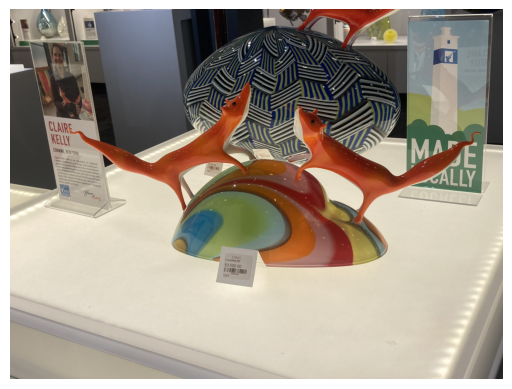

In [5]:
plt.figure()
plt.imshow(image_rgb) #use as comparison to original image
plt.plot()
plt.axis('off')

In [6]:
#own SAM, with shown masks on image
sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator_ = SamAutomaticMaskGenerator(model=sam,
                                            points_per_side=2,
                                            pred_iou_thresh=0.6,
                                            stability_score_thresh=0.6,
                                            crop_n_layers=0
                                            )

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [.35]])
        img[m] = color_mask
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(image_rgb)
masks = mask_generator_.generate(image_rgb)
show_anns(masks)
plt.show() 

KeyboardInterrupt: 